In [1]:
import sys, os, os.path
if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("..", "..","ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset


In [2]:
from data.pilot import load_pilot_series, list_pilot_series

# list_pilot_series()
dataset = load_pilot_series()

Loading: AOT
Loading: AP
Loading: BTS
Loading: CPF
Loading: KBANK
Loading: KSL
Loading: LH
Loading: PTT
Loading: RATCH
Loading: SCB
Loading: SET
Loading: SET100
Loading: SET50


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os, os.path
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [39]:
# Load data series and clean-up missing values
def prep_series_for_XGBoost(df, window=50):
    data = df
    # Target: Tomorrow's closing price
    data.loc[:,("Tomorrow")] = data["Price"].shift(-1)
    # data.dropna(inplace=True)

    # Past: Historical data
    features = []
    for i in range(window):
        f_col = "price-%s-day-ago" % i
        data.loc[:,(f_col)] = data["Close"].shift(i)
        features.append(f_col)

    # Target: Future time
    targets = []
    for t in [1,3,5,7,10,15,20,30]:
        t_col = "%s-day-ahead" % t
        data.loc[:,(t_col)] = data["Close"].shift(-t)
        targets.append(t_col)

    # Initial Setup XGBoost.
    # Run with 5 TI: SMA WMA ADOSC ATR RSI
    # Only use Closing price
    # df = data[['Price','1-day-ahead']]
    df = data[['Close'] + features + targets]
    return df, features, targets

df_series, features, targets = prep_series_for_XGBoost(dataset['SET50'], window=50)
df_series.dropna(inplace=True) # Remove NA row
df_series.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Close,price-0-day-ago,price-1-day-ago,price-2-day-ago,price-3-day-ago,price-4-day-ago,price-5-day-ago,price-6-day-ago,price-7-day-ago,price-8-day-ago,...,price-48-day-ago,price-49-day-ago,1-day-ahead,3-day-ahead,5-day-ahead,7-day-ahead,10-day-ahead,15-day-ahead,20-day-ahead,30-day-ahead
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-08,1103.55,1103.55,1106.15,1093.50,1096.79,1092.58,1068.71,1073.26,1075.91,1066.48,...,1096.47,1083.32,1092.69,1088.37,1081.78,1084.27,1077.51,1070.23,1047.02,1065.23
2019-11-11,1092.69,1092.69,1103.55,1106.15,1093.50,1096.79,1092.58,1068.71,1073.26,1075.91,...,1095.04,1096.47,1095.68,1085.44,1085.81,1075.77,1089.67,1054.88,1048.85,1067.99
2019-11-12,1095.68,1095.68,1092.69,1103.55,1106.15,1093.50,1096.79,1092.58,1068.71,1073.26,...,1085.80,1095.04,1088.37,1081.78,1084.27,1073.10,1083.70,1054.28,1057.87,1070.74
2019-11-13,1088.37,1088.37,1095.68,1092.69,1103.55,1106.15,1093.50,1096.79,1092.58,1068.71,...,1099.93,1085.80,1085.44,1085.81,1075.77,1077.51,1084.13,1053.40,1066.63,1068.72
2019-11-14,1085.44,1085.44,1088.37,1095.68,1092.69,1103.55,1106.15,1093.50,1096.79,1092.58,...,1108.91,1099.93,1081.78,1084.27,1073.10,1089.67,1077.30,1048.76,1048.08,1068.50


Text(0.5, 1.0, 'Data partition')

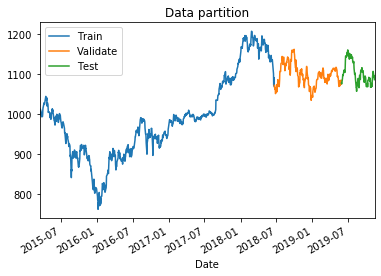

In [40]:
df = df_series
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


fig, ax = plt.subplots()
train_df['Close'].plot(ax=ax)
val_df['Close'].plot(ax=ax)
test_df['Close'].plot(ax=ax)
ax.legend(['Train', 'Validate', 'Test'])
plt.title("Data partition")

In [41]:
# train_df[features]

train_df

,Close,price-0-day-ago,price-1-day-ago,price-2-day-ago,price-3-day-ago,price-4-day-ago,price-5-day-ago,price-6-day-ago,price-7-day-ago,price-8-day-ago,...,price-48-day-ago,price-49-day-ago,1-day-ahead,3-day-ahead,5-day-ahead,7-day-ahead,10-day-ahead,15-day-ahead,20-day-ahead,30-day-ahead
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-16,996.39,996.39,1012.25,1013.98,1015.94,1005.25,1027.02,1032.49,1022.09,1027.89,...,980.50,987.40,997.43,1012.18,1006.03,1002.56,993.27,1027.62,1039.53,1003.19
2015-03-17,997.43,997.43,996.39,1012.25,1013.98,1015.94,1005.25,1027.02,1032.49,1022.09,...,998.05,980.50,1010.99,1010.67,1005.12,992.82,997.66,1023.97,1033.75,990.69
2015-03-18,1010.99,1010.99,997.43,996.39,1012.25,1013.98,1015.94,1005.25,1027.02,1032.49,...,1013.24,998.05,1012.18,1006.03,1002.56,993.33,1010.04,1023.65,1040.23,1001.04
2015-03-19,1012.18,1012.18,1010.99,997.43,996.39,1012.25,1013.98,1015.94,1005.25,1027.02,...,1017.87,1013.24,1010.67,1005.12,992.82,993.27,1015.30,1025.38,1024.61,996.27
2015-03-20,1010.67,1010.67,1012.18,1010.99,997.43,996.39,1012.25,1013.98,1015.94,1005.25,...,1019.38,1017.87,1006.03,1002.56,993.33,997.66,1017.08,1043.73,1019.38,986.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-15,1117.85,1117.85,1121.70,1128.55,1135.11,1131.83,1130.91,1141.12,1145.95,1141.39,...,1165.17,1175.24,1100.25,1090.62,1071.18,1065.20,1051.63,1063.71,1080.05,1127.56
2018-06-18,1100.25,1100.25,1117.85,1121.70,1128.55,1135.11,1131.83,1130.91,1141.12,1145.95,...,1136.72,1165.17,1071.96,1068.68,1061.68,1060.58,1058.12,1069.83,1069.04,1143.46
2018-06-19,1071.96,1071.96,1100.25,1117.85,1121.70,1128.55,1135.11,1131.83,1130.91,1141.12,...,1147.21,1136.72,1090.62,1071.18,1065.20,1050.60,1069.77,1085.36,1068.09,1132.47


In [42]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

with pd.option_context('mode.chained_assignment', None):
    # Suppress warning: https://www.dataquest.io/blog/settingwithcopywarning/
    train_df[features] = sc.fit_transform(train_df[features])
    val_df[features] = sc.transform(val_df[features])


In [46]:
X = train_df[features].values  # .values so becomes numpy array to feed to model. Ex. diabetes = datasets.load_diabetes()
y = train_df[['1-day-ahead']].values    # Check that dimension and type same as example dataset: diabetes.data, diabetes.target

X.shape, y.shape

((798, 50), (798, 1))

In [47]:
X_train = train_df[features].values
y_train = train_df[['1-day-ahead']].values

X_test = val_df[features].values
y_test = val_df[['1-day-ahead']].values

In [48]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_train, reg.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

params

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 133.7156


In [52]:
params = {'n_estimators': 1000,
          'max_depth': 10,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_train, reg.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

params # Overfit

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 206.0441


{'n_estimators': 1000,
 'max_depth': 10,
 'min_samples_split': 5,
 'learning_rate': 0.01,
 'loss': 'ls'}

In [53]:
params = {'n_estimators': 1000,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_train, reg.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 140.1989


# Try 3, 5, 7, 10, 15, 20, 30

In [54]:
params_set = {}

params_set[1] = {'n_estimators': 500,
              'max_depth': 4,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}
params_set[2] = {'n_estimators': 1000,
              'max_depth': 10,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}
params_set[3] = {'n_estimators': 1000,
              'max_depth': 5,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}

models = []

for fh in 3, 5, 7, 10, 15, 20, 30:
    print("Forecast: %s-day ahead" % fh)
    for k, params in params_set.items():
        print("Parameter Set: %s" % k)
        reg = ensemble.GradientBoostingRegressor(**params)
        
        X_train = train_df[features].values
        y_train = train_df[['%s-day-ahead' % fh]].values

        X_test = val_df[features].values
        y_test = val_df[['%s-day-ahead' % fh]].values
        
        reg.fit(X_train, y_train)

        mse = mean_squared_error(y_train, reg.predict(X_train))
        print("The mean squared error (MSE) on train set: {:.4f}".format(mse))

        mse = mean_squared_error(y_test, reg.predict(X_test))
        print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 133.0530
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 208.2103
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 139.6062
Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 132.9665
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 209.0063
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 140.1858
Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 133.6817
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 208.2067
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 141.6114
Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 132.8031
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 204.5048
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 141.4862
Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 134.5973
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 208.2473
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 140.1577
Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 133.7526
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 209.0933
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 141.4050
Forecast: %s-day ahead
Parameter Set: 1


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 23.4393
The mean squared error (MSE) on test set: 134.3678
Parameter Set: 2


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 0.0001
The mean squared error (MSE) on test set: 208.8344
Parameter Set: 3


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on train set: 4.4640
The mean squared error (MSE) on test set: 140.4479
